# RÉALISEZ UNE APPLICATION DE RECOMMANDATION DE CONTENU

<img src="mySaves/images/myContentLogo.png" alt="logo_myContent" width="400" class="center"/>

# SOMMAIRE

# 0. PRÉAMBULE

## 0.1. Imports

Commençons par charger les librairies nécessaires

In [94]:
# import necessary packages

# manipulate files
import os
from joblib import load, dump
# manipulate data
import pandas as pd
import numpy as np
# plots
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import seaborn as sns
# custom functions
import myFunctions as mf
%load_ext autoreload
%autoreload 2
# datetime
import dateutil.relativedelta
import datetime
# collaborative filtering
from surprise import Reader, Dataset, accuracy
from surprise import SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
# other tools
import time
import gc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Créons un dossier pour nos sauvegardes :

In [2]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")

## 0.2. Le projet

## 0.3. Charger et explorer les données

### 0.3.1. Les fichiers à notre disposition

Les données représentent les intéractions avec des utilisateurs avec les articles disponibles. Elles sont organisées en plusieurs parties :
- **clicks** :
    - `clicks_sample.csv`
    - `clicks/` :
        - `clicks_hour_000.csv`
        - `clicks_hour_001.csv`
        - ...
        - `clicks_hour_383.csv`
        - `clicks_hour_384.csv`
- **articles** :
    - `articles_metadata.csv`
    - `articles_embeddings.pickle`

### 0.3.2. Les données *clicks*

#### 0.3.2.1. Échantillon

Regardons tout d'abord le fichier `clicks_sample.csv` :

In [3]:
# load clicks_sample in a dataframe
clicks_sample_df = pd.read_csv("news-portal-user-interactions-by-globocom/clicks_sample.csv")
clicks_sample_df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


Ce fichier est un échantillon et nous permet de comprendre les différentes features à notre disposition. Regardons chacune d'elle grâce à la fonction `myDescribe` :

In [4]:
# use custom function "myDescribe" on "clicks_sample_df"
mf.myDescribe(clicks_sample_df)

Output()

Les features sont décrites ici : https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom?select=clicks_sample.csv

Ce que l'on peut en retenir :
- `user_id` : l'identifiant de l'utilisateur
- `session_id` : un identifiant donnée à la session dans laquelle le click a lieu. Tous les clicks d'une session d'utilisation ont donc le même identifiant
- `session_start` : horodatage du début de la session. De type *Unix time*, mais en **ms**
- `session_size` : nombre de clicks dans la session d'utilisation. Pour le fichier échantillon, compris entre 2 et 46.
- `click_article_id` : identifiant de l'article sur lequel le click a eu lieu
- `click_timestamp` : horodatage du click
- `click_environment` : environnement d'utilisation (`1` - *Facebook Instant Article*, `2` - *Mobile App*, `3` - *AMP (Accelerated Modile Pages)*, `4` - Web). Pour l'échantllon, la grande majorité des clicks ont eu lieu sur le site web.
- `click_deviceGroup` : type d'appareil utilisé (`1` - Tablette, `2` - télévision, `3` - vide (inconnu), `4` - smartphone, `5` - ordinateur de bureau)
- `click_os` : système d'exploitation de l'appareil. Peut être considérée comme catégorielle.
- `click_country` : identifiant donné au pays de l'utilisateur. La plupart des clicks ont été effectués depuis le pays 1.
- `click_region` : identifiant donné à la région de l'utilisateur
- `click_referrer_type` : inconnu

Mise à part `session_size`, `click_timestamp` et `session_start`, les colonnes peuvent être considérées comme catégorielles.

In [5]:
del clicks_sample_df
gc.collect()

0

#### 0.3.2.2. Charger toutes les données *clicks*

Chargeons maintenant l'ensemble des données `clicks_hour_xxx`. Pour cela nous avons rédigé une fonction `read_all_clicks` :

In [58]:
# create folder for saving
if not os.path.isdir("mySaves/working_dfs"):
    os.mkdir("mySaves/working_dfs")

In [73]:
# use custom function "read_all_clicks"
if "clicks_df.joblib" not in os.listdir("mySaves/working_dfs") : 
    clicks_df = mf.read_all_clicks(clicks_folder_path="news-portal-user-interactions-by-globocom/clicks", usecols = None)
    # save
    # clicks_df.to_csv(path_or_buf="mySaves/working_dfs/clicks_df.csv", index=False)
    dump(clicks_df, "mySaves/working_dfs/clicks_df.joblib")
    
else :
    # load
    clicks_df = load("mySaves/working_dfs/clicks_df.joblib")


#### 0.3.2.3. La taille de la session `session_size`

Regardons la distribution de `session_size` :

In [7]:
# create folder for saving
if not os.path.isdir("mySaves/images"):
    os.mkdir("mySaves/images")
if not os.path.isdir("mySaves/images/plots"):
    os.mkdir("mySaves/images/plots")

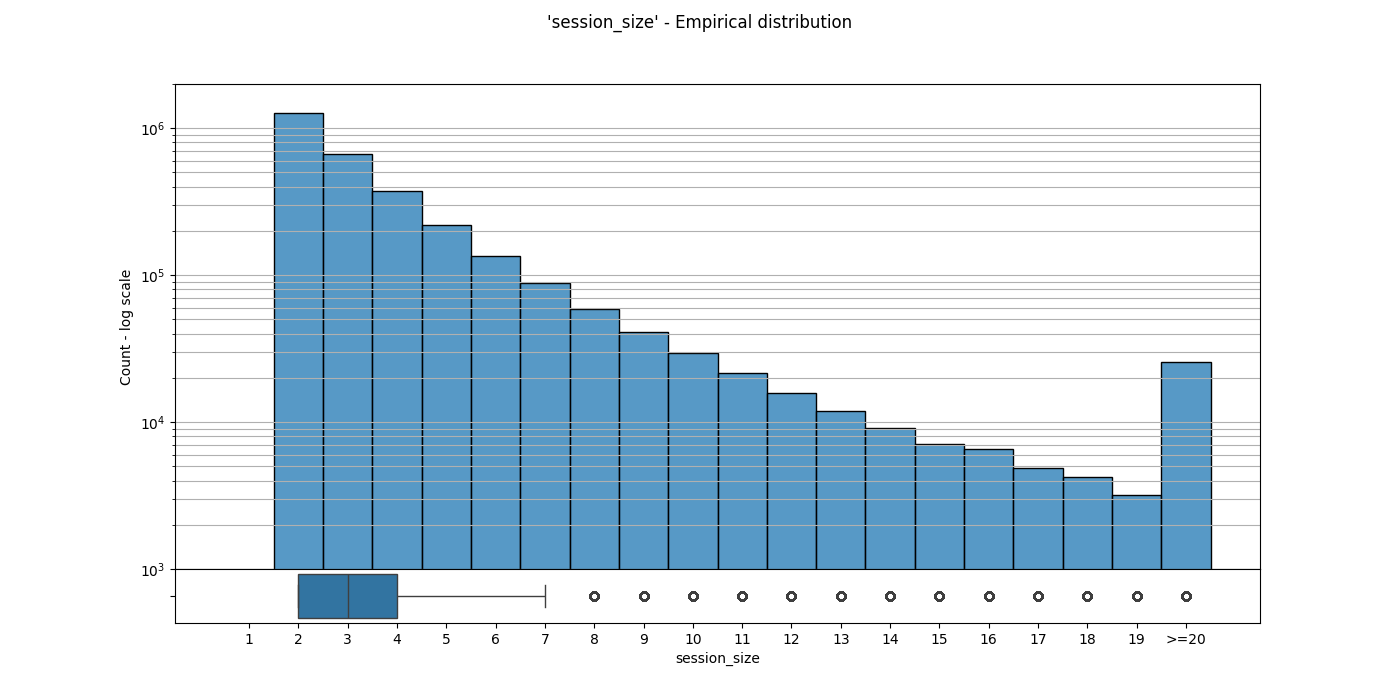

In [8]:
# plot distribution of "session_size"

if "distrib_session_size.png" not in os.listdir("mySaves/images/plots") :
    # create figure
    fig, (ax_hist, ax_box) = plt.subplots(2,1,figsize=(14,7), height_ratios=[0.9,0.1], sharex=True)

    # no space between plots
    plt.subplots_adjust(hspace=0)

    # clip values
    upper = 20
    session_size_clip = clicks_df["session_size"].clip(lower=0, upper=upper)

    ## boxplot

    sns.boxplot(x=session_size_clip, ax=ax_box)

    ## histogram

    # plot
    sns.histplot(session_size_clip, bins=upper, binrange=(0.5,upper+0.5), ax=ax_hist)

    # y logscale
    ax_hist.set_yscale("log")
    ax_hist.set_ylabel("Count - log scale")
    ax_hist.set_ylim(10**3,2*10**6)
    ax_hist.grid(True, axis="y", which='both')

    # x tick labels
    xticks = np.arange(1,upper+1)
    ax_hist.set_xticks(ticks=xticks, labels=[str(i) for i in xticks[:-1]]+[">="+str(upper)])
    ax_hist.tick_params(axis="x", bottom=False)

    # title
    fig.suptitle("'session_size' - Empirical distribution")

    fig.savefig(fname="mySaves/images/plots/distrib_session_size.png")

    plt.show()

else :
    # load image
    display(Image.open("mySaves/images/plots/distrib_session_size.png"))
    

Ce que l'on peut en retenir :
- il n'existe pas une seule session avec un click unique. Il s'agit peut-être d'un choix opéré par le créateur du dataset
- nous avons été contraint de tracer le graph avec une échelle logarithmique : la très grande majorité des sessions comporte peu de clicks

#### 0.3.2.4. Les données temporelles `session_start` et `click_timestamp`

Maintenant que ces features sont converties en type `datetime`, observons-les de nouveau :

In [9]:
# use custom function myDescribe on datetime features
mf.myDescribe(clicks_df[["session_start", "click_timestamp"]])

Output()

Ce que l'on peut retenir :
- les sessions de notre dataset ont démarré entre le 1er octobre et le 17 octobre 2017
- la grande majorité des clicks s'étale sur cette même période
- il y a cependant des clicks survenus bien après, jusqu'à 13 novembre...
- ces cas sont peu nombreux

Les temps de session doivent être alors anormalement élevés :

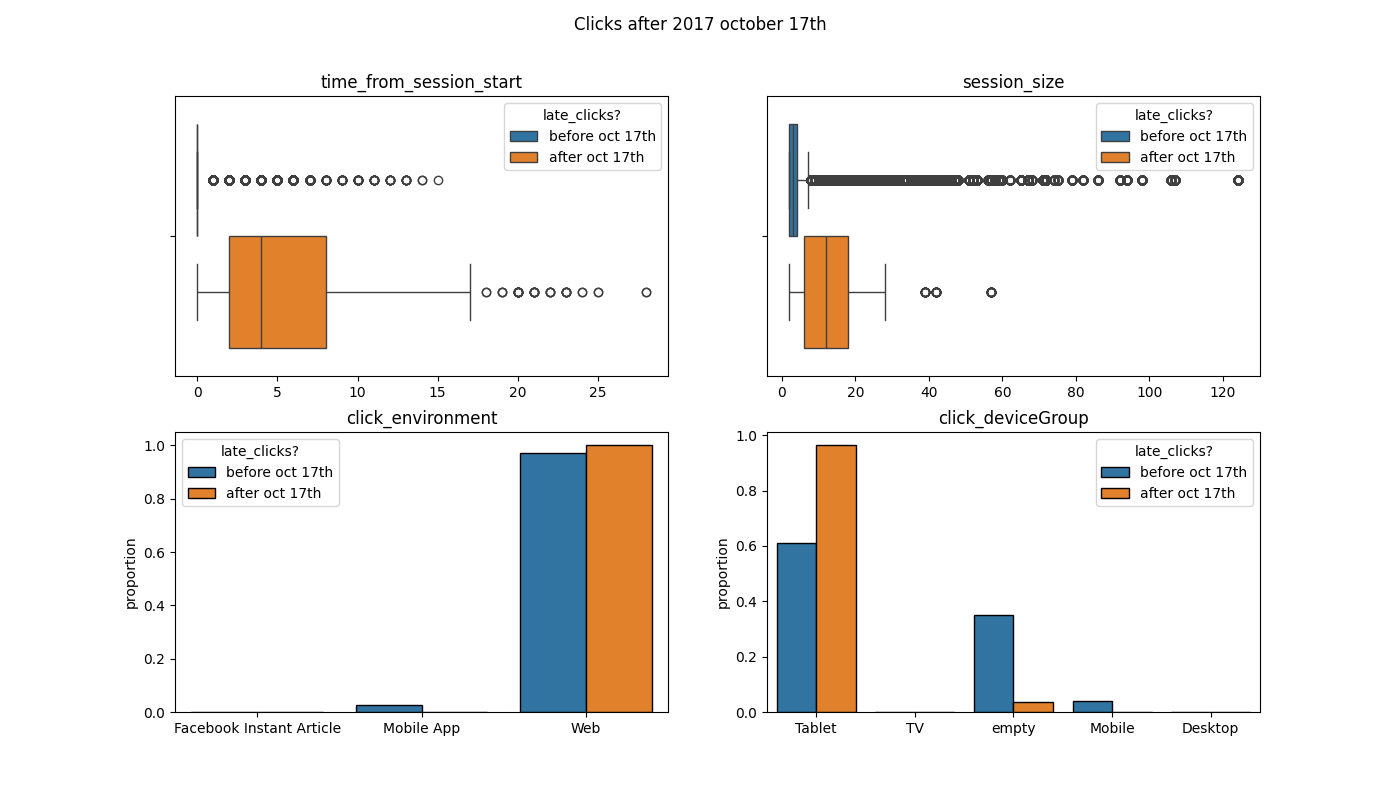

In [10]:
# explore clicks after october 17th

if "late_clicks_explore.png" not in os.listdir("mySaves/images/plots") :

    # make copy
    explore_late_clicks = clicks_df.copy()
    # compute time between the click and session start
    explore_late_clicks["time_from_session_start (in days)"] = (explore_late_clicks["click_timestamp"] - explore_late_clicks["session_start"]).dt.days
    # feature to tag clicks after october 17th
    explore_late_clicks["late_clicks?"] = explore_late_clicks["click_timestamp"].apply(lambda x : "after oct 17th" if x > datetime.datetime(year=2017, month=10, day=18) else "before oct 17th")

    ## plot "time_from_session_start", "session_size", "click_environment", "click_deviceGroup" distributions by "late_clicks?"

    # create figure
    fig, axs = plt.subplots(2,2, figsize=(14,8))
    axs = axs.flatten()

    # box plots for "time_from_session_start" and "session_size"
    sns.boxplot(data=explore_late_clicks, x="time_from_session_start (in days)", hue="late_clicks?", ax=axs[0])
    sns.boxplot(data=explore_late_clicks, x="session_size", hue="late_clicks?", ax=axs[1])

    # barplots for "click_environment" and "click_deviceGroup"
    for ax, col in zip([axs[2], axs[3]],["click_environment", "click_deviceGroup"]) :
        # create mask to filter "explore_late_clicks" by "late_clicks?"
        mask = explore_late_clicks["late_clicks?"] == "after oct 17th"
        # filter and "value_counts"
        late_prop = explore_late_clicks.loc[mask, col].value_counts(normalize=True).to_frame()
        late_prop["late_clicks?"] = "after oct 17th"
        casual_prop = explore_late_clicks.loc[~mask, col].value_counts(normalize=True).to_frame()
        casual_prop["late_clicks?"] = "before oct 17th"
        # concatenate
        prop = pd.concat([casual_prop, late_prop]).reset_index()
        # plot
        sns.barplot(data=prop, x=col, y="proportion", hue="late_clicks?", ax=ax, edgecolor="k")

    # titles
    for i,col in enumerate(["time_from_session_start", "session_size", "click_environment", "click_deviceGroup"]) :
        axs[i].set_title(col)
        axs[i].set_xlabel("")
    fig.suptitle("Clicks after 2017 october 17th")

    # save
    fig.savefig("mySaves/images/plots/late_clicks_explore.png")

    plt.show()

    del explore_late_clicks
    gc.collect()

else :
    # load image
    display(Image.open("mySaves/images/plots/late_clicks_explore.png"))

On voit effectivement que les **durées de sessions sont majoritairement plus élevées après le 17 octobre 2017**, date de la dernière session prise en compte dans le dataset.

On peut penser à un bug, ou bien à un navigateur resté ouvert.

On remarque en effet que, passée cette date, 100% de l'utilisation s'est faite sur la **page web** de l'application, en très grande majorité depuis une tablette. L'application ne doit pas déconnecter automatiquement l'utilisateur passé une certaine durée.

Nous ne prendrons donc **pas en compte la taille de la session `session_size`** dans notre projet sur la recommendation, celle-ci n'étant pas vraiment représentative de la réalité.

En revanche il pourrait être intéressant d'utiliser `click_timestamp` pour notre système de notation *Collaborative Filtering*. **Il serait en effet pertinent que le *rating* prennent en compte le degré d'ancienneté de la consommation du contenu**.

#### 0.3.2.3. Les identifiants `user_id`, `session_id`, `click_article_id`

Regardons les identifiants, qui pourront nous aider à contruire notre système de notation.

In [11]:
# use custom function myDescribe on id features
mf.myDescribe(clicks_df[["user_id", "session_id", "click_article_id"]])

Output()

Ce que l'on peut en retenir :
- `user_id` : certains utilisateurs sont très actifs
- `session_id` : certaines sessions sont très longues, ce qui est étonnant
- `click_article_id` : nous avons **46033 articles différents** lus par les utilisateurs

On peut combiner ces `id` et nous intéresser aux articles lus par utilisateurs :
- combien ?
- certains ont-ils était lus plusieurs fois (plusieurs clicks) ?

In [12]:
# explore "click_df" by "user_id"

# create a dictionnary with aggregation functions
aggDict = {"click_article_id" : ["count", "nunique", mf.n_duplicates]}
# aggregate
clicks_by_uid = clicks_df.groupby(by="user_id", observed=True).agg(func=aggDict)
# handle columns names
clicks_by_uid.columns = [col[0]+"_"+col[1].upper() for col in clicks_by_uid.columns]
# use custom function myDescribe
mf.myDescribe(clicks_by_uid)

Output()

Ce que l'on peut en retenir :
- La grande majorité des utilisateurs ont lu moins de 10 articles
- Il y a cependant des utilisateurs très actifs qui perturbent la distribution. Il faudra **prendre garde à cela dans la construction de notre système de notation**
- Concernant les doublons, les utilisateurs ont, dans presque l'ensemble, logiquement lu chaque article une seule fois
- Certains ont cependant lu plusieurs fois certains articles. **Ce comportement mérite d'être étudié**

Regardons un exemple :

In [13]:
# filter "clicks_by_uid" on "N_DUPLICATES" == 209 (the max)
clicks_by_uid.loc[clicks_by_uid["click_article_id_N_DUPLICATES"]==209]

,click_article_id_COUNT,click_article_id_NUNIQUE,click_article_id_N_DUPLICATES
user_id,,,
2151,722,513,209
15867,900,691,209


Regardons par exemple l'utilisateur `2151`, sur ses 30 dernier clicks :

In [14]:
# filter on user 2151
clicks_df.loc[clicks_df.user_id == 2151].head(30)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
2915502,2151,1508174265282981,2017-10-16 17:17:45,5,87213,2017-10-16 23:13:45.152,Web,Tablet,17,1,21,7
2915501,2151,1508174265282981,2017-10-16 17:17:45,5,30409,2017-10-16 23:13:15.152,Web,Tablet,17,1,21,7
2915500,2151,1508174265282981,2017-10-16 17:17:45,5,292594,2017-10-16 23:11:52.712,Web,Tablet,17,1,21,7
2932356,2151,1508179555122841,2017-10-16 18:45:55,6,285433,2017-10-16 21:48:42.928,Web,Tablet,17,1,21,2
2932355,2151,1508179555122841,2017-10-16 18:45:55,6,206415,2017-10-16 21:48:12.928,Web,Tablet,17,1,21,2
2932354,2151,1508179555122841,2017-10-16 18:45:55,6,277107,2017-10-16 21:48:08.121,Web,Tablet,17,1,21,2
2932353,2151,1508179555122841,2017-10-16 18:45:55,6,158772,2017-10-16 21:47:42.758,Web,Tablet,17,1,21,2
2932352,2151,1508179555122841,2017-10-16 18:45:55,6,36162,2017-10-16 21:47:28.860,Web,Tablet,17,1,21,2
2915499,2151,1508174265282981,2017-10-16 17:17:45,5,109727,2017-10-16 20:19:16.477,Web,Tablet,17,1,21,7
2915498,2151,1508174265282981,2017-10-16 17:17:45,5,109752,2017-10-16 20:19:11.541,Web,Tablet,17,1,21,7


Ce que l'on observe :
- sachant que les clicks sont dans l'ordre, on observe que les **sessions sont entremêlées**. Cela pourrait venir de l'ouverture de plusieurs onglets ?
- il y a bien des doublons :
    - l'article `206415` apparaît 2 fois à presque 2 heures d'intervalle, dans 2 sessions différentes
    - l'article `277107` apparaît 3 fois à 1/2 heure et 6 heures d'intervalle, dans 3 sessions différentes
    - etc.
- les doublons n'apparaissent jamais au sein d'une même session, ce que l'on peut vérifier :

In [15]:
clicks_df.loc[clicks_df[["click_article_id","session_id"]].duplicated()]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type


Nous ne considérerons **pas ces doublons dans le système de notation** Collaborative Filtering, ce qui n'aurait pas vraiment de sens.

Mais alors chaque article se verra attribuer la même note ?

Pour éviter cela nous allons **pondérer** les notes **en fonction du niveau d'engagement des utilisateurs**. Nous considérons qu'un utilisateur moins consommateur de contenus a plus tendance à sélectionner avec soin. Dans le cas inverse, un utilisateur ultra actif n'est peut-être pas aller au bout des articles sur lesquels il a cliqué.

### 0.3.3. Les données *articles_metadata*

In [16]:
# load articles_metadata in a dataframe
meta_raw = pd.read_csv("news-portal-user-interactions-by-globocom/articles_metadata.csv")
meta_raw

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


Ce fichier est un échantillon et nous permet de comprendre les différentes features à notre disposition. Regardons chacune d'elle grâce à la fonction `myDescribe` :

In [17]:
# use custom function "myDescribe" on "meta_df"
mf.myDescribe(meta_raw)

Output()

Les features sont décrites ici : https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom?select=clicks_sample.csv

Ce que l'on peut en retenir :
- `article_id` : l'identifiant de l'article, le même que `click_article_id`
- `category_id` : un identifiant donnée à la catégorie de l'article. 
- `created_at_ts` : horodatage de la rédaction de l'article. De type *Unix time*, mais en **ms**
- `publisher_id` : l'identifiant de l'éditeur. **Inutilisable** car ne comporte qu'une seule valeur.
- `words_count` : nombre de mots dans l'article

Mise à part `created_at_ts`, et `words_count`, les colonnes peuvent être considérées comme catégorielles.

In [18]:
# delete meta_raw
del meta_raw
gc.collect()

0

#### 0.3.3.1. Charger `articles_metadata` avec les bons dtypes

In [19]:
# use custom function to load and prepare "articles_metadata.csv"
meta_df = mf.read_meta(meta_path="news-portal-user-interactions-by-globocom/articles_metadata.csv")
# use custom function "myDescribe"
mf.myDescribe(meta_df)

Output()

Ce que l'on peut en retenir :
- `article_id` : 
    - il y a 364047 articles renseignés dans la base de données
    - pour rappel seul **46033 articles ont été lus à date par les utilisateurs**
    - pour notre étude nous pourrons donc **nous concentrer uniquement sur ces articles**
- `words_count` : 
    - La majorité des articles comporte entre 150 et 250 mots
    - Il y a de rares articles beaucoup plus longs
- `created_at_ts` : 
    - les articles ont été créés entre 2005 et 2018
    - pour rappel le dernier click a été effectué en novembre 2017
    - vérifions la cohérence des dates sur les 46033 articles effectivement lus :


#### 0.3.3.2. Filtrer `articles_metadata` sur les article lus

Commençons par extraire la liste des `click_article_id` :

In [20]:
# extract unique "click_article_id"
unique_click_article_ids = clicks_df["click_article_id"].cat.categories

In [21]:
# filter meta_df
meta_df = meta_df.loc[meta_df["article_id"].isin(unique_click_article_ids)]

# use myDescribe
mf.myDescribe(meta_df)

Output()

Les dates de création d'article sont bien cohérentes : il n'y pas d'article de 2018.

Il pourrait être intéressant de prendre en compte la date de parution de l'article pour le modèle *content-base*.

# 1. Modéliser grâce au Collaborative Filtering

## 1.1. Construire un système de notation

Nous allons construire notre système de notation. Comme vu précédemment, celui-ci sera construit de la manière suivante :
- une première composante basée sur le fait que l'**utilisateur ait cliqué sur l'article** :
    - sans décompter les **doublons** (nous faisons l'hypothèse qu'un article n'est **réellement** lu qu'une fois par utilisateur)
    - normalisée par le **nombre d'articles différents lus par l'utilisateur**
- une seconde basée sur **l'"ancienneté" du click** :
    - qui mesure l'**éloignement du click depuis une date du référence**
    - normalisée par la **durée maximale**
    - la très grande majorité des intéractions ayant eu lieu avant le **18 octobre 2017**, nous prendrons cette date comme référence

In [77]:
# use custom functions to create ratings
if "data_cf.joblib" not in os.listdir("mySaves/working_dfs") :
    # create copy
    data_cf = clicks_df.copy()[["user_id", "click_article_id", "click_timestamp"]]
    # del useless dfs
    del clicks_df, clicks_by_uid, meta_df
    gc.collect()

    # create ratings
    data_cf["seniority_rating"] = mf.my_seniority_rating (
        ts_series=data_cf["click_timestamp"], 
        ref_date=datetime.datetime(year=2017, month=10, day=18),
        min_seniority=0,
        max_seniority=None
        )

    data_cf["interaction_rating"] = mf.my_interaction_rating (
        user_series=data_cf["user_id"], 
        article_series=data_cf["click_article_id"]
        )

    # get rid of duplicates
    # we keep "last", the oldest 
    data_cf.drop_duplicates(subset=["user_id", "click_article_id"], inplace=True, keep="last")

    # test combinations
    data_cf["main_rating_MEAN"] = data_cf[["seniority_rating", "interaction_rating"]].mean(axis=1)
    data_cf["main_rating_PROD"] = data_cf["seniority_rating"] * data_cf["interaction_rating"]

    # save
    dump(data_cf, "mySaves/working_dfs/data_cf.joblib")

else :
    #load
    data_cf = load("mySaves/working_dfs/data_cf.joblib")

In [ ]:
data_cf

,user_id,click_article_id,click_timestamp,seniority_rating,interaction_rating,main_rating_MEAN,main_rating_PROD
2941947,320431,145309,2017-11-13 20:04:14.886,1.0,0.125000,0.562500,0.125000
2941946,320431,203538,2017-11-13 20:03:44.886,1.0,0.125000,0.562500,0.125000
2583367,252642,96333,2017-11-07 22:31:52.860,1.0,0.071429,0.535714,0.071429
2583366,252642,207672,2017-11-07 22:31:22.860,1.0,0.071429,0.535714,0.071429
2108105,201738,224148,2017-11-04 12:27:02.502,1.0,0.018519,0.509259,0.018519
...,...,...,...,...,...,...,...
187,70,119592,2017-10-01 03:00:18.863,0.0,0.200000,0.100000,0.000000
295,111,202436,2017-10-01 03:00:14.140,0.0,0.038462,0.019231,0.000000
399,154,96663,2017-10-01 03:00:04.207,0.0,0.021739,0.010870,0.000000
208,79,159359,2017-10-01 03:00:01.702,0.0,0.500000,0.250000,0.000000


Nous pouvons explorer ces notations :

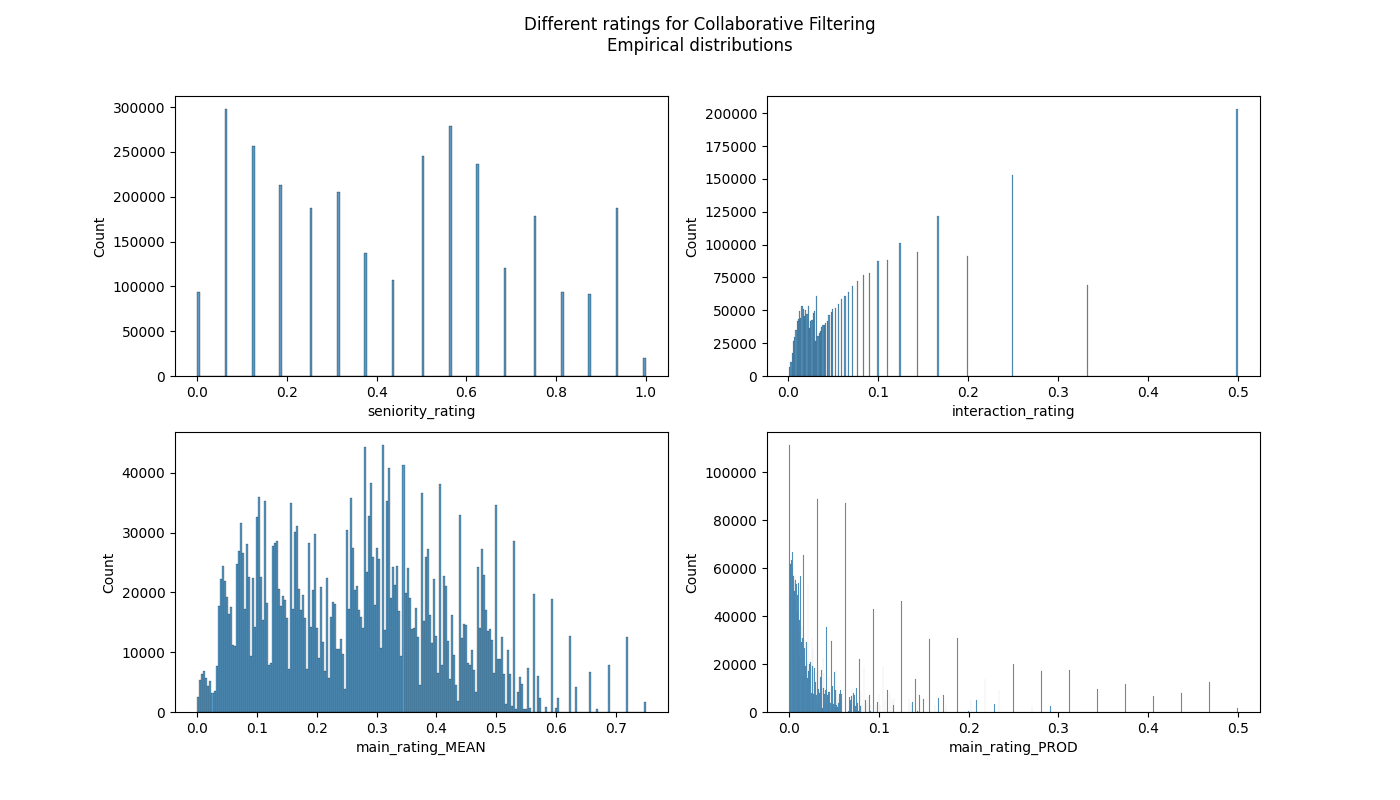

In [81]:
# explore "seniority_rating", "interaction_rating" and their combinations

if "cf_ratings_explore.png" not in os.listdir("mySaves/images/plots") :

    ## plot "seniority_rating", "interaction_rating" and their combinations

    # create figure
    fig, axs = plt.subplots(2,2, figsize=(14,8))
    axs = axs.flatten()

    # plot
    for i, col in enumerate(["seniority_rating", "interaction_rating", "main_rating_MEAN", "main_rating_PROD"]) :
        sns.histplot(data_cf[col], ax=axs[i])

    # title
    fig.suptitle("Different ratings for Collaborative Filtering\nEmpirical distributions")

    # save
    fig.savefig("mySaves/images/plots/cf_ratings_explore.png")

    plt.show()

else :
    # load image
    display(Image.open("mySaves/images/plots/cf_ratings_explore.png"))

In [ ]:
del data_cf
gc.collect()

## 1.2. Préparer le dataset pour `surprise`

Nous pouvons maintenant créer notre dataframe qui servira de base pour la collaborative filtering avec la librairie `surprise` :

In [83]:
# use custom function to create a dataframe for surprise
if "X_cf.joblib" not in os.listdir("mySaves/working_dfs") :
    X_cf = mf.read_clicks_and_prepare_rating(
        clicks_folder_path="news-portal-user-interactions-by-globocom/clicks", 
        ref_date_for_seniority=datetime.datetime(year=2017, month=10, day=18)
        )

    # save
    dump(X_cf, "mySaves/working_dfs/X_cf.joblib")

else :
    # load
    X_cf = load("mySaves/working_dfs/X_cf.joblib")

In [89]:
# split train/test
# test set is the 10% last clicks

# index
test_index = np.arange(0, int(0.1*len(X_cf)))
train_index = np.arange(int(0.1*len(X_cf)), len(X_cf))
# filter
X_cf_test = X_cf.loc[test_index]
X_cf_train = X_cf.loc[train_index]

Nous allons créer des datasets `surprise` à partir de ces dataframe :

In [92]:
# create a surprise dataset

# create reader with rating scale from 0 to 1
reader = Reader(rating_scale=(0,1))

# create Dataset
X_cf_test = Dataset.load_from_df(X_cf_test, reader=reader)
X_cf_train = Dataset.load_from_df(X_cf_train, reader=reader)

Pour la sélection du modèle par validation croisée, nous fixons un `KFold`

In [96]:
# create a KFold cross-validation iterator
cv = KFold(n_splits=5, random_state=16, shuffle=True)

## 1.3. Tester différents modèles

Nous allons tester différents modèles de Collaborative Filtering avec la librairie `surprise`. Initions un tableau pour stocker nos résultats :

In [114]:
# create a tab to save RMSE results
cf_results = pd.DataFrame(columns=["model_name", "parameters", "mean_RMSE_CV", "mean_training_time_CV"])

In [115]:
# create folder for saving
if not os.path.isdir("mySaves/cf_results"):
    os.mkdir("mySaves/cf_results")

### 1.3.1. Probabilistic Matrix Factorization

Testons d'abord le modèle `SVD` avec `biased = False`, équivalent au modèle `Probabilistic Matrix Factorization` :

In [116]:
if "PMF_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate model
    model = SVD(biased=False)
    # cross validation
    results = cross_validate(algo=model, data=data_cf_train, measures=["rmse"], cv=cv, n_jobs=12, verbose = True)
    # save
    dump(results, "mySaves/cf_results/PMF_results.joblib")
else :
    # load
    results = load("mySaves/cf_results/PMF_results.joblib")
# add results to tab
cf_results.loc[len(cf_results)] = [
    "PMF",
    dict(n_factors=100, n_epochs=20, biased=False, lr_all=0.005, reg_all=0.02),
    results["test_rmse"].mean(),
    np.array(results["fit_time"]).mean()
]

In [117]:
cf_results

,model_name,parameters,mean_RMSE_CV,mean_training_time_CV
0,PMF,"{'n_factors': 100, 'n_epochs': 20, 'biased': F...",0.138234,23.076921


### 1.3.2. Singular Value Decomposition

Testons d'abord le modèle `SVD` avec `biased = True` :

In [118]:
if "SVD_raw_results.joblib" not in os.listdir("mySaves/cf_results") :
    # initiate model
    model = SVD(biased=True)
    # cross validation
    results = cross_validate(algo=model, data=data_cf_train, measures=["rmse"], cv=cv, n_jobs=12, verbose = True)
    # save
    dump(results, "mySaves/cf_results/SVD_raw_results.joblib")
else :
    # load
    results = load("mySaves/cf_results/SVD_raw_results.joblib")
# add results to tab
cf_results.loc[len(cf_results)] = [
    "SVD_raw",
    dict(n_factors=100, n_epochs=20, biased=True, lr_all=0.005, reg_all=0.02),
    results["test_rmse"].mean(),
    np.array(results["fit_time"]).mean()
]

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0910  0.0913  0.0912  0.0911  0.0908  0.0911  0.0001  
Fit time          22.39   23.68   24.27   24.04   23.31   23.54   0.66    
Test time         5.97    5.89    5.27    4.74    4.31    5.24    0.64    


In [119]:
cf_results

,model_name,parameters,mean_RMSE_CV,mean_training_time_CV
0,PMF,"{'n_factors': 100, 'n_epochs': 20, 'biased': F...",0.138234,23.076921
1,SVD_raw,"{'n_factors': 100, 'n_epochs': 20, 'biased': T...",0.091089,23.537904


In [ ]:
param_grid = {
    'n_factors': [50, 75, 100, 125, 150, 200]
    'n_epochs': [10, 20, 30, 40, 50],
    'lr_all': [0.001, 0.0025, 0.005, 0.01],
    'reg_all': [0.005, 0.01, 0.02, 0.04, 0.08, 0.1],
             }



Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.0883  0.0882  0.0881  0.0882  0.0001  
Fit time          16.19   16.40   16.63   16.41   0.18    
Test time         8.05    7.79    7.45    7.76    0.25    


{'test_rmse': array([0.08830442, 0.08823361, 0.0881355 ]),
 'fit_time': (16.193794012069702, 16.40474247932434, 16.62914776802063),
 'test_time': (8.050828218460083, 7.789491415023804, 7.449393033981323)}

# 2. Modélisation *Content Base*

## 2.1. Préparer les données

Commençons par charger les données `clicks` et `articles_metadata` dans un seul dataframe :

In [26]:
# load, prepare and merge "clicks" and "articles_metadata" CSVs

# necessary columns
clicks_usecols = [
    'user_id', 
    'click_article_id', 
    'click_timestamp',
    ]
meta_usecols = [
    'article_id', 
    'created_at_ts'
]

# unnecessary columns (only used for preparation (sorting) and merging)
drop_after_prep_cols = [
    "click_article_id", 
    "click_timestamp"
]

# use custom function
data_cb = mf.read_clicks_and_meta(
    clicks_folder_path="news-portal-user-interactions-by-globocom/clicks",
    meta_path="news-portal-user-interactions-by-globocom/articles_metadata.csv",
    clicks_usecols=clicks_usecols,
    meta_usecols=meta_usecols,
    drop_after_prep_cols=drop_after_prep_cols
    )

data_cb

,user_id,article_id,created_at_ts
0,320431,145309,2017-11-14 13:26:54
1,320431,203538,2017-11-13 12:43:39
2,252642,96333,2017-11-07 16:17:51
3,252642,207672,2017-11-07 17:46:15
4,201738,224148,2017-11-03 09:23:08
...,...,...,...
2988176,70,119592,2017-09-30 15:11:56
2988177,111,202436,2017-09-30 16:15:43
2988178,154,96663,2017-09-30 16:13:45
2988179,79,159359,2017-09-30 07:43:36


In [27]:
max_seniority = 365

# clip 
test = (data["created_at_ts"].max() - data["created_at_ts"]).dt.days.clip(0,max_seniority)

# normalise
test = 1 - (test - 0) / (max_seniority - 0)

# 
test.hist()

NameError: name 'data' is not defined